<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 10th exercise: <font color="#C70039">Interpretable Machine Learning by means of Shapley Values</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Rubaiya Kabir Pranti</a>
* Matriculation Number: <a href="https://www.gernotheisenberg.de/"> 11146364</a>
* Date:   16.01.2024

<img src="https://shap.readthedocs.io/en/latest/_images/example_notebooks_overviews_An_introduction_to_explainable_AI_with_Shapley_values_13_0.png" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**:
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole.

**GENERAL NOTE 2**:
* Please, when commenting source code, just use English language only.
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:

Before using Shapley values to explain complicated models, it is helpful to understand how they work for simple models.

In this respect the example in this notebook computes a model for the titanic data set (downloaded from Kaggle) and uses its outputs for explanation of feature importance using SHAP deepexplainer. In addition, several different visualization techniques (plots) for Shapley values are going to be demonstrated.

For a description of the features please refer to <a href="https://www.kaggle.com/competitions/titanic/data">Kaggle Titanic data set</a>.

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points.
If a task is more challenging and consists of several steps, this is indicated as well.
Make sure you have worked down the task list and commented your doings.
This should be done by using markdown.<br>
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date.
    * set the date too and remove mine.
3. read the entire notebook carefully
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
4. Develop a CNN for image classification and adapt the Shapley Value idea to that model. Comment your entire code.  
---------------------------------

## Imports
Import all necessary python utilities.

In [1]:
!pip install shap

# **Execution for both titanic and mnist dataset**
# ***1. Titanic***

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import os
%matplotlib inline
import shap
import warnings
warnings.filterwarnings('ignore')

## load build-in dataset
take the titanic data set

In [3]:
#os.chdir('./data/titanic/')
train_data = pd.read_csv('/content/train.csv', index_col=0)
test_data = pd.read_csv('/content/test.csv', index_col=0)
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing
Since the titanic data is a raw data set there is a need to preprocess it by dropping unnecessary columns, handling missing data, converting categorical features to numeric features and conducting one-hot encoding.

In [4]:
def data_preprocessing(df):

    df = df.drop(columns=['Name', 'Ticket', 'Cabin'])

    # fill na
    df[['Age']] = df[['Age']].fillna(value=df[['Age']].mean())
    df[['Embarked']] = df[['Embarked']].fillna(value=df['Embarked'].value_counts().idxmax())
    df[['Fare']] = df[['Fare']].fillna(value=df[['Fare']].mean())

    # encode categorical features into numeric
    df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

    # one-hot encoding
    embarked_one_hot = pd.get_dummies(df['Embarked'], prefix='Embarked')

    df = df.drop('Embarked', axis=1)
    df = df.join(embarked_one_hot)

    return df

# training data processing
train_data = data_preprocessing(train_data)
train_data.isnull().sum()

# create data for training
x_train = train_data.drop(['Survived'], axis=1).values

# Check testing data
test_data.isnull().sum()

# normalize training data
scale = StandardScaler()
x_train = scale.fit_transform(x_train)

# prepare y_train
y_train = train_data['Survived'].values

# preprocess testing data
test_data = data_preprocessing(test_data)
x_test = test_data.values.astype(float)

# normalize testing data
x_test = scale.transform(x_test)

# Check testing data
test_data.isnull().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

### Build a simple vanilla ANN, compile and fit the model.

In [5]:
model = Sequential()
model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# fit model
model.fit(x_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
14/14 [==============================] - 2s 4ms/step - loss: 0.6910 - accuracy: 0.5455
Epoch 2/100
14/14 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.6857
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 0.5775 - accuracy: 0.7340
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5403 - accuracy: 0.7306
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5334 - accuracy: 0.7497
Epoch 6/100
14/14 [==============================] - 0s 5ms/step - loss: 0.5079 - accuracy: 0.7643
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 0.5150 - accuracy: 0.7553
Epoch 8/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5029 - accuracy: 0.7587
Epoch 9/100
14/14 [==============================] - 0s 5ms/step - loss: 0.4567 - accuracy: 0.7957
Epoch 10/100
14/14 [==============================] - 0s 3ms/step - loss: 0.4889 - accuracy: 0.7800
Epoch 11/

### Now, compute the Shapley values

In [6]:
explainer = shap.DeepExplainer(model, x_train)
shap_values = explainer.shap_values(x_test) # for test dataaset

In [7]:
x_test.shape

(418, 9)

In [8]:
shap_values #test dataset

[array([[ 6.48467078e-02,  1.62343675e-01, -1.88581425e-04, ...,
          1.62816136e-02,  7.38058393e-02, -2.40365591e-02],
        [ 1.44338160e-01, -2.16649733e-01,  3.57379728e-02, ...,
         -7.50609503e-03,  1.12320434e-02,  2.66658920e-02],
        [ 3.59386606e-04,  1.76505886e-01,  1.07745947e-01, ...,
          1.24366406e-02,  3.76432004e-02, -1.82916375e-02],
        ...,
        [ 5.81624645e-02,  1.35858305e-01,  3.53640592e-02, ...,
          4.26872088e-03, -3.61287495e-03,  9.52678418e-03],
        [ 6.08643806e-02,  1.38958352e-01,  9.18113790e-03, ...,
          6.55053660e-03, -2.55913474e-03,  9.10640038e-03],
        [ 7.48251786e-02,  1.21192617e-01,  1.51297501e-02, ...,
         -5.58744070e-02,  6.68377613e-04, -5.16798216e-04]]),
 array([[-6.48467305e-02, -1.62343679e-01,  1.88599514e-04, ...,
         -1.62816145e-02, -7.38058908e-02,  2.40365888e-02],
        [-1.44338155e-01,  2.16649728e-01, -3.57379725e-02, ...,
          7.50609533e-03, -1.12320436e

### Shapley values interpretation

The summary plot shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

## For test dataset

## Global interpretation method
### summary plot

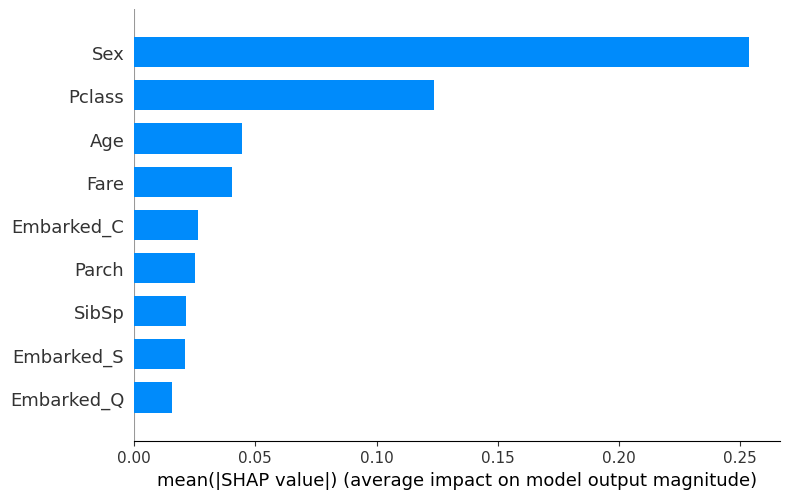

In [9]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = test_data.columns)

## Local Interpretation methods
### waterfall
The waterfall plot allows for seeing the amplitude and the nature of the impact of a feature.
It also allows for seeing the order of importance of the features and the values taken by each feature for the sample.

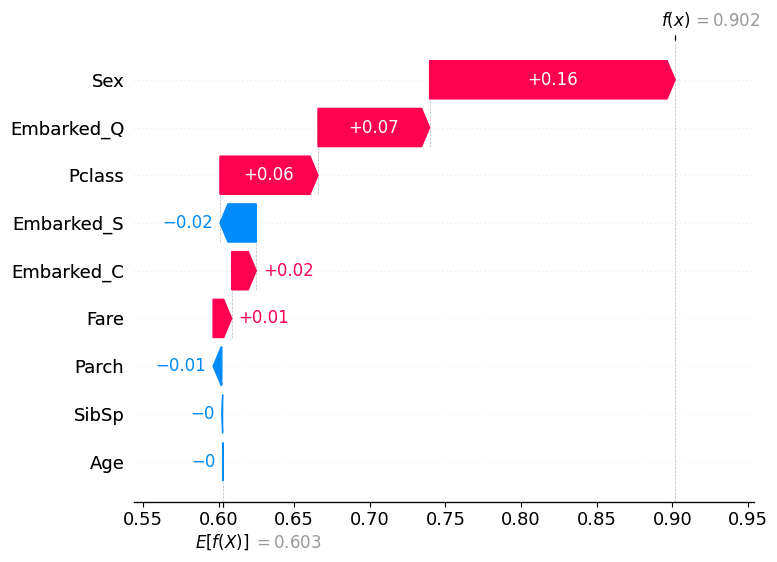

In [10]:
# visualizing the first prediction's explanation
#shap.plots.waterfall(explainer.expected_value[0].numpy(), shap_values[0][0])
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][0], feature_names = test_data.columns)

# **Comment on waterfall:**<br>
The above explanation shows features each contributing to push the model output from the base value, E(f(X)) (the average model output over the training dataset) towards the model output. Features pushing the prediction higher are shown in red arrows, those pushing the prediction lower are in blue arrows.

## Local Interpretation methods
### Force plot
The force plot is great for seeing where the “output value” fits in relation to the “base value”.
Further, it is possible to observe which features have a positive (red) or negative (blue) impact on the prediction and in addition the magnitude of the impact.

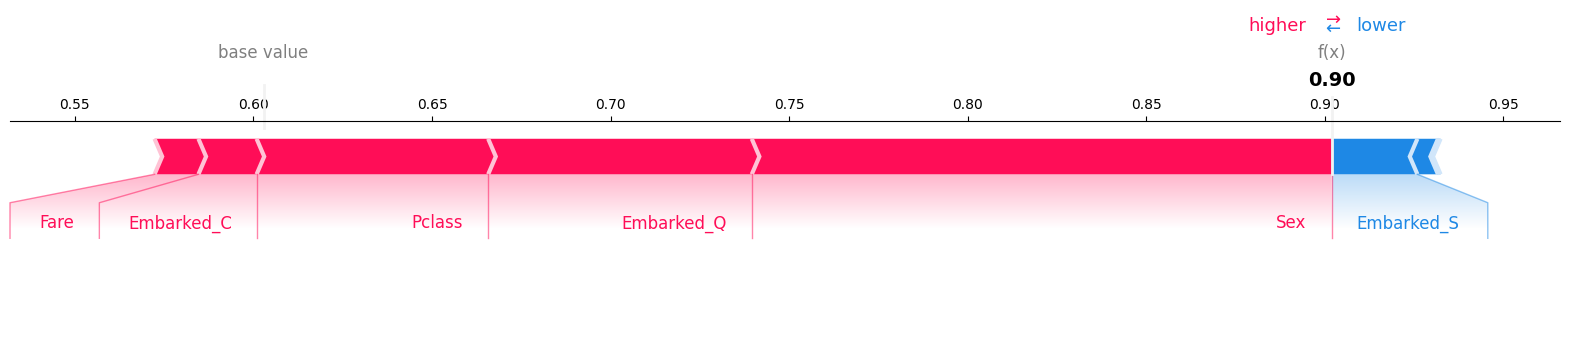

In [11]:
# visualizing the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], matplotlib=True, features = test_data.columns)

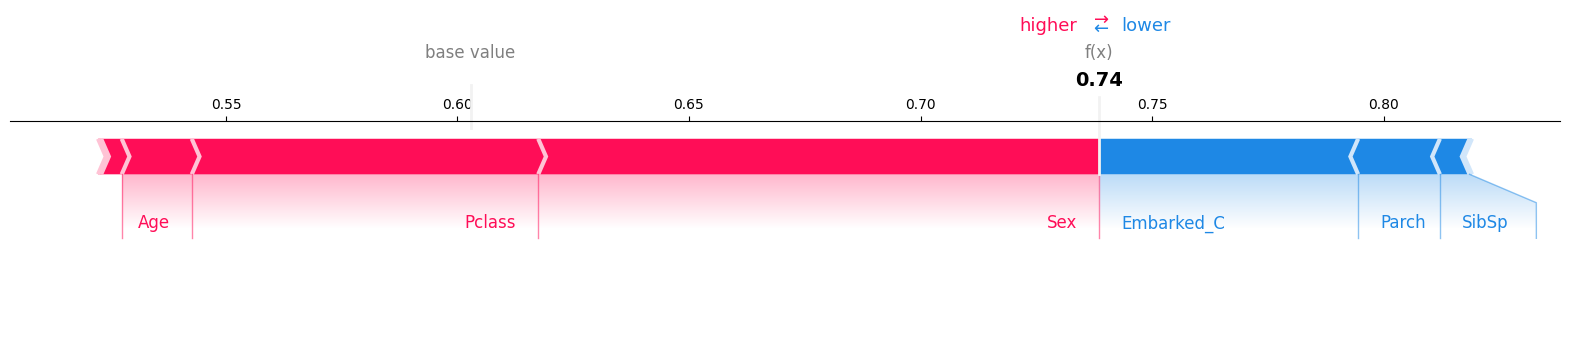

In [12]:
shap.plots.force(explainer.expected_value[0].numpy(), shap_values[0][417], matplotlib=True, features = test_data.columns)

## Decision plot
The decision plot enables to observe the amplitude of each change taken by a sample for the values of the displayed features.

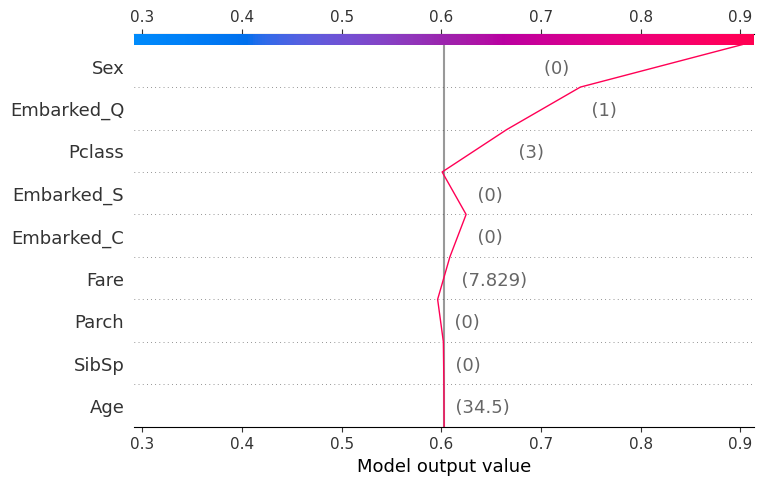

In [13]:
shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = test_data.iloc[0,:], feature_names = test_data.columns.tolist())

# ***2. Mnist Dataset***

In [14]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import os
%matplotlib inline
import shap
import warnings
warnings.filterwarnings('ignore')

## loading mnist dataset

In [15]:
# loading MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## normalizing

In [16]:
# reshape and normalize data
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255

In [17]:
y_train.shape

(60000,)

In [18]:
x_train.shape

(60000, 28, 28, 1)

# Build a simple CNN, compile and fit the model

In [19]:
# the model architecture for MNIST
inputs = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

## inputs and outputs
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mnist_shap_model")

# compiling the model for MNIST
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
      #SparseCategoricalCrossentropy is designed for scenarios where the classes are represented as integers (0...9)
  )
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 10)

Epoch 1/10
1875/1875 [==============================] - 62s 33ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.9610 - val_loss: 0.0492 - val_sparse_categorical_accuracy: 0.9841
Epoch 2/10
1875/1875 [==============================] - 83s 45ms/step - loss: 0.0419 - sparse_categorical_accuracy: 0.9868 - val_loss: 0.0429 - val_sparse_categorical_accuracy: 0.9862
Epoch 3/10
1875/1875 [==============================] - 87s 46ms/step - loss: 0.0278 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.0323 - val_sparse_categorical_accuracy: 0.9895
Epoch 4/10
1875/1875 [==============================] - 74s 39ms/step - loss: 0.0205 - sparse_categorical_accuracy: 0.9937 - val_loss: 0.0287 - val_sparse_categorical_accuracy: 0.9914
Epoch 5/10
1875/1875 [==============================] - 76s 40ms/step - loss: 0.0155 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.0322 - val_sparse_categorical_accuracy: 0.9895
Epoch 6/10
1875/1875 [==============================] - 61s 33ms/step - loss: 0.

## predict on the test set (one image for each class)
### 10 different instances

In [20]:
# class label list for MNIST
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# example image for each class for MNIST
images_dict = dict()
#y train > array of labels for the training dataset
for i, l in enumerate(y_train):
    if len(images_dict) == 10:
        break
    if l not in images_dict.keys():
        # reshaping to 28x28 for MNIST and add a channel dimension
        images_dict[l] = x_train[i].reshape((28, 28, 1))
images_dict = dict(sorted(images_dict.items()))

# example images for each class for the test set (total 10 images as representatives)
x_test_dict = dict()
for i, l in enumerate(y_test):
    if len(x_test_dict) == 10:
        break
    if l not in x_test_dict.keys():
        # Reshape to 28x28 for MNIST and add a channel dimension
        x_test_dict[l] = x_test[i].reshape((28, 28, 1))

# Order by class for MNIST
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
#x_test_each_class specifically has to have one representative image per digit class
x_test_each_class = np.asarray(x_test_each_class)

# Compute predictions for MNIST
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 130ms/step


In [21]:
predicted_class

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [22]:
x_test_each_class.shape

(10, 28, 28, 1)

## Visualization
#### plot function
define a plot function for actual and predicted class

In [23]:
# plot actual and predicted class
def plot_actual_predicted(images, pred_classes):
    fig, axes = plt.subplots(1, 11, figsize=(16, 15))
    axes = axes.flatten()

    # plot
    ax = axes[0]
    dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
    ax.set_title("Base reference")
    ax.set_axis_off()
    ax.imshow(dummy_array, interpolation='nearest')

    # plot image
    for k,v in images.items():
        ax = axes[k+1]
        ax.imshow(v, cmap=plt.cm.binary)
        ax.set_title(f"True: %s \nPredict: %s" % (class_names[k], class_names[pred_classes[k]]))
        ax.set_axis_off()

    #plt.tight_layout()
    plt.show()

#### XAI using SHAP
Now use the SHAP library to generate the Shapley values

The baseline is often an average prediction over a set of background examples.The background dataset provides a reference for SHAP values to understand how each feature contributes towards moving the model's prediction away from this baseline.

In [24]:
# selecting background for shap
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]
#creating a subset of the training data to be used as the background dataset

# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)
# explainer is our base reference value

# the shapley values
shap_values = explainer.shap_values(x_test_each_class)

## plot the Shapley values

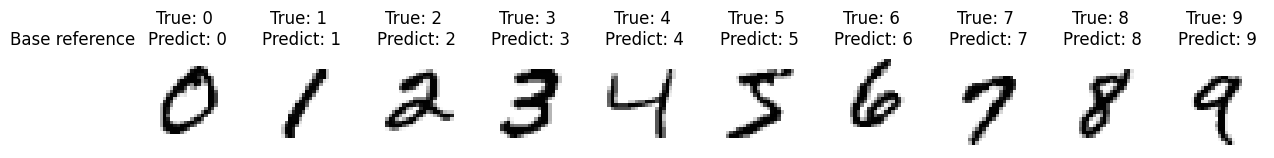

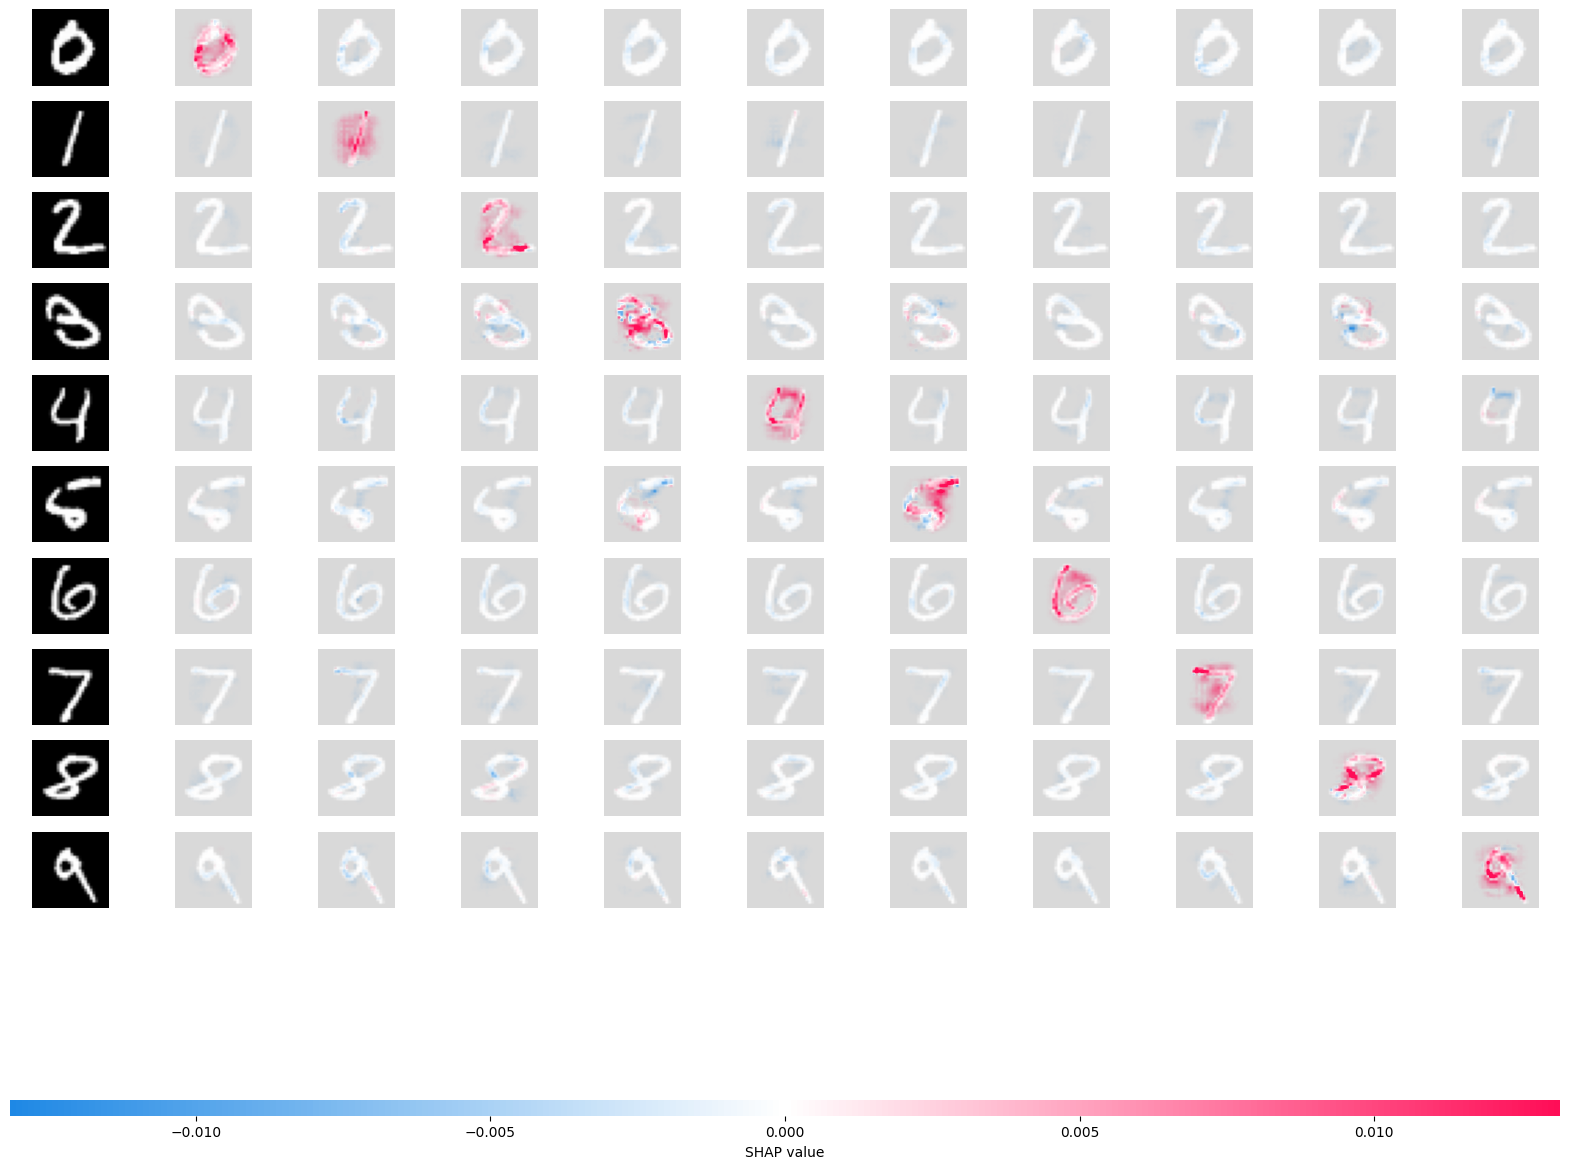

In [25]:
plot_actual_predicted(images_dict, predicted_class)
print()
shap.image_plot(shap_values, x_test_each_class)

## <font color="FFC300">Comment</font>:
The plot above refers to ten different outputs(columns) which are (digits 0-9) for 10 different images(horizontal or row ones). Usually, in shapley calculation, we take one instance or one image only to see the waterfall plot clearly. However, like the tabular data, the red pixels increase the model's output or prediction while the blue pixels decrease the output. Our input images (x_test_each_class) are shown on the left and the parallel, transparent grayscale images are detailed visualizations for explanations.